# Testing PYMC v4

<br>

***

<br>

## Connections & Imports

In [33]:
##### Import Libraries #####

# Data
import pandas as pd
import numpy as np
%run C:\\Users\\a1274500\\ds_projects\\MSCI-TDAM\\tdam_functions\\tdam.py

# Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Frquentist Analysis
import statsmodels.api as sm
import scipy as sp
from scipy import stats

# Bayesian Analysis
import arviz as az
az.style.use('arviz-darkgrid')
import pymc as pm
from scipy.stats import distributions as dist
print(f"Running on PyMC v{pm.__version__}")

# CAM Connection

##### Connect to Database #####
import pyodbc
conn = pyodbc.connect(dsn = 'NZSQL', autocommit = False)

Running on PyMC v4.1.2


C:\Users\a1274500\AppData\Local\Temp\ipykernel_11488\4199357036.py:29: DeprecationWarning: PyUnicode_FromUnicode(NULL, size) is deprecated; use PyUnicode_New() instead
  conn = pyodbc.connect(dsn = 'NZSQL', autocommit = False)


In [2]:
##### Importing Data #####
# Starting with Parquet import for ease
df = pd.read_parquet('C:\\Users\\a1274500\\ds_projects\\tdam411_analytics_testvscontrol.parquet')
df.head()

,CID_CUST_ID,ELITE_PLUS,CONTROL_GROUP,LAST365_REV,LAST180_BROWSE_CNT,CC_HOLDER,LAST180_CLICK_CNT,LAST180_DELIVER_CNT,VAL_RDM_12,LAST60_ECC_CALL_FLG,...,ATT_NBR,GSP_NBR,CHAN,NBRINTEGER,VP_ID,PUSH_DLVR,PRE_TOTALTECH,CAMP_TOTALTECH,POST_TOTALTECH,TT_DATE
0,100410544,0,1,2529.91,5,0,0,0,0.0,0,...,0,0,0,0,None,0,0,0,0,NaT
1,104255163,0,0,499.99,0,0,2,191,0.0,0,...,0,0,0,0,None,0,0,0,0,NaT
2,104569087,1,0,7202.91,8,0,8,187,565.0,0,...,0,0,0,0,None,0,0,0,0,NaT
3,106651359,0,0,0.00,0,0,0,215,0.0,0,...,0,0,0,0,None,0,0,0,0,NaT
4,107997540,1,0,8186.79,4,0,0,0,55.0,0,...,0,0,0,0,None,0,0,0,0,NaT


<br>

***

<br>

## Analysis

<br>

### Question 1: Did the mailer increase Totaltech signups?

In [3]:
### Value Counts for rank & totaltech signups
print(df['RNK'].value_counts())
print(df['CAMP_TOTALTECH'].value_counts())

CTL    2834700
MLD     500000
Name: RNK, dtype: int64
0    3323953
1      10747
Name: CAMP_TOTALTECH, dtype: int64


<AxesSubplot:xlabel='CAMP_TOTALTECH', ylabel='RNK'>

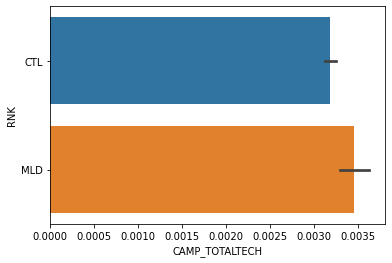

In [4]:
### Visualize
sns.barplot(data=df,x='CAMP_TOTALTECH',y='RNK')

<br>

#### Frequentists

In [5]:
### Run a t-test and a chi square test

# Assign variables to object
mail = df[df['RNK']=='MLD']['CAMP_TOTALTECH']
ctrl = df[df['RNK']=='CTL']['CAMP_TOTALTECH']

# Run stat tests
chi2,cp,dof,ex = stats.chi2_contingency(pd.crosstab(df['RNK'],df['CAMP_TOTALTECH']))
ts,tp = stats.ttest_ind(df[df['RNK'] == 'MLD']['CAMP_TOTALTECH'],df[df['RNK'] == 'CTL']['CAMP_TOTALTECH'], equal_var=False)

# Compute treatment effects
ate = mail.mean() - ctrl.mean()
lift = ate / ctrl.mean()
pval = stats.ttest_ind(mail,ctrl).pvalue

print(f"Chi-Square P-Value: {cp}")
print("")
print(f"T-Test P-Value: {tp}")
print("")
print(f"Average Treatment Effect: {ate}")
print("")
print(f"Percent Lift: {lift}")
print("")
print(f"P-Value: {pval}")

Chi-Square P-Value: 0.002205171497934306

T-Test P-Value: 0.0027956971880523226

Average Treatment Effect: 0.00026729989064098493

Percent Lift: 0.08398525825759255

P-Value: 0.0021075412676172306


<br>

#### Bayesian

- https://towardsdatascience.com/bayesian-a-b-testing-in-pymc3-54dceb87af74

##### Finding Priors Part 1

In [39]:
# 3125/480768
prior_data = [0.0065,0.0065,0.0065,0.0075,0.0075,0.0055,0.0055,0.0045,0.0085,0.0065]
a,b,_,_ = dist.beta.fit(prior_data,floc=0,fscale=1)

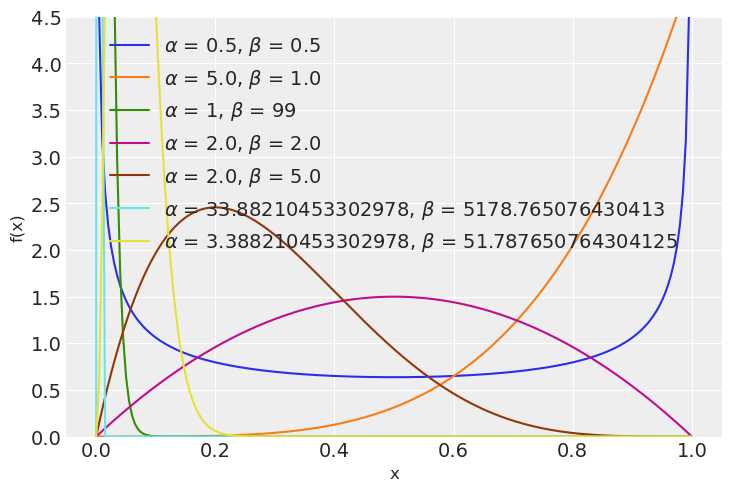

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import arviz as az
plt.style.use('arviz-darkgrid')
x = np.linspace(0, 1, 200)
alphas = [.5, 5., 1, 2., 2., a, a/10]
betas = [.5, 1., 99, 2., 5., b, b/100]
for a, b in zip(alphas, betas):
    pdf = st.beta.pdf(x, a, b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

##### Finding Priors Part 2

In [49]:
dens = 0.85
lower = 0.001
upper = 0.01
constrained_priors = pm.find_constrained_prior(pm.Beta,lower=lower,upper=upper,mass=dens,init_guess=dict(alpha=33,beta=5178))

##### Bayesian Inference

In [58]:
### What did we know about Totaltech signups before this? - Estimated based on historical counts at 0.65%; that is now our prior probability
with pm.Model() as model: # 1. Open up your model! All of your parameters are now indented.
    
    # 3. What did our prior look like --- go above to see how we figure this out!
    # mail_prior = pm.Beta('mail_prior',a,b)
    # ctrl_prior = pm.Beta('ctrl_prior',a,b)
    mail_prior = pm.Beta('mail_prior',**constrained_priors)
    ctrl_prior = pm.Beta('ctrl_prior',**constrained_priors)
    
    # 2. Likelihood: What your data looks like - distribution & inputs
    mailed = pm.Bernoulli('mailed',mail_prior,observed=df[df['RNK']=='MLD']['CAMP_TOTALTECH'])
    control = pm.Bernoulli('control',ctrl_prior,observed=df[df['RNK']=='CTL']['CAMP_TOTALTECH'])
    
    trace_abtest = pm.sample(100,return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mail_prior, ctrl_prior]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 247 seconds.


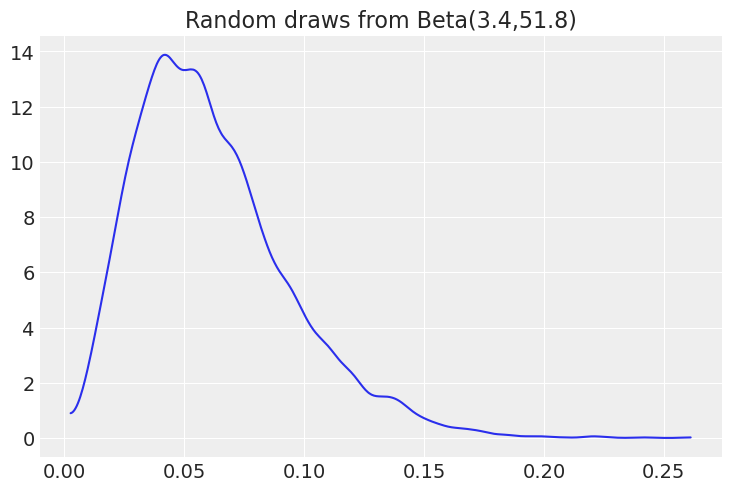

In [59]:
### Graphing Priors from scipy priors 1
draws = pm.draw(mail_prior,draws=10000)
ax = az.plot_dist(draws)
ax.set_title(
    f"Random draws from Beta({round(a,1)},{round(b,1)})"
);

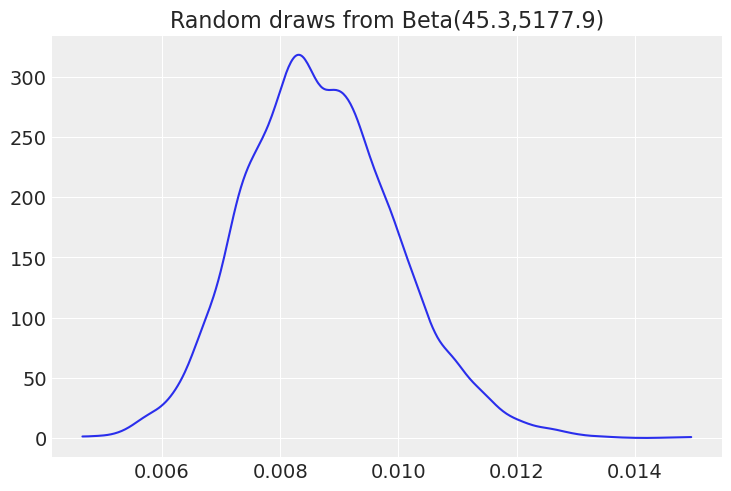

In [52]:
### Graphing Priors from constrained priors 2
draws = pm.draw(mail_prior,draws=10000)
ax = az.plot_dist(draws)
ax.set_title(
    f"Random draws from Beta({round(constrained_priors['alpha'],1)},{round(constrained_priors['beta'],1)})"
);

array([<AxesSubplot:title={'center':'mail_prior'}>,
       <AxesSubplot:title={'center':'ctrl_prior'}>], dtype=object)

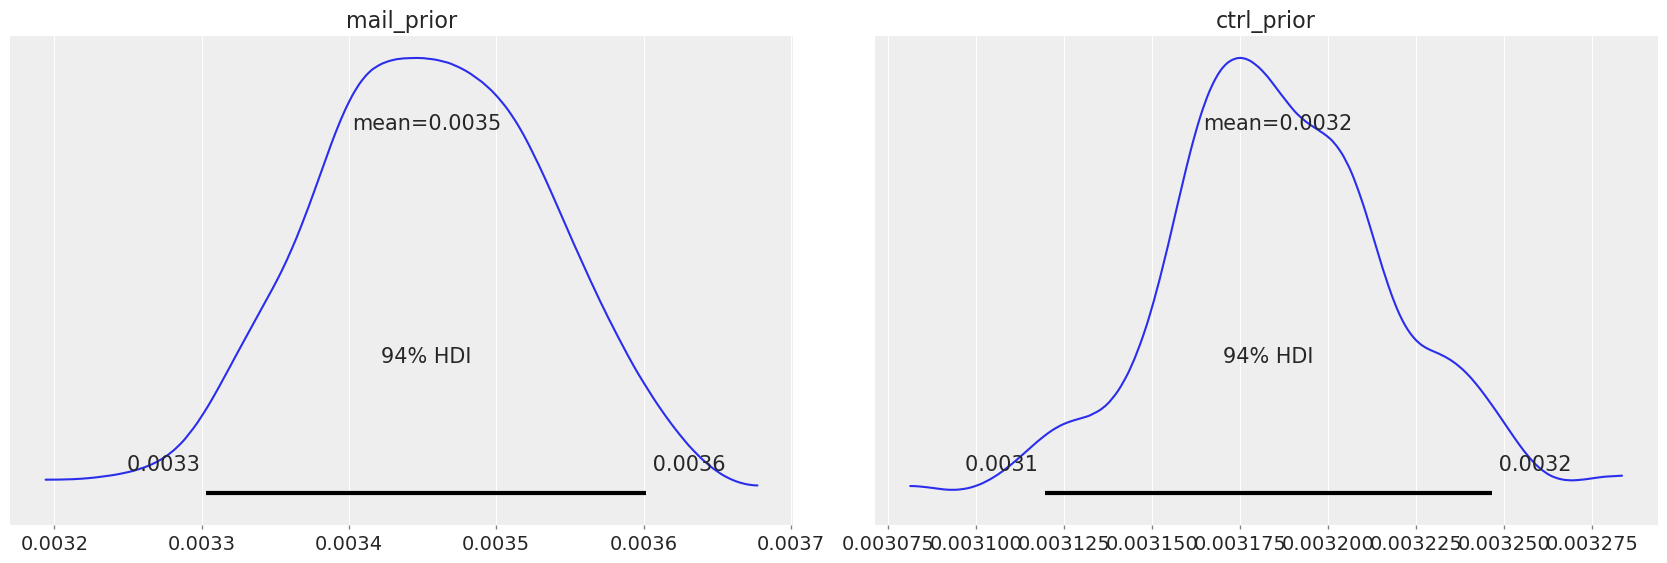

In [60]:
### Plot Posterior - priors 1
az.plot_posterior(trace_abtest)

array([<AxesSubplot:title={'center':'mail_prior'}>,
       <AxesSubplot:title={'center':'ctrl_prior'}>], dtype=object)

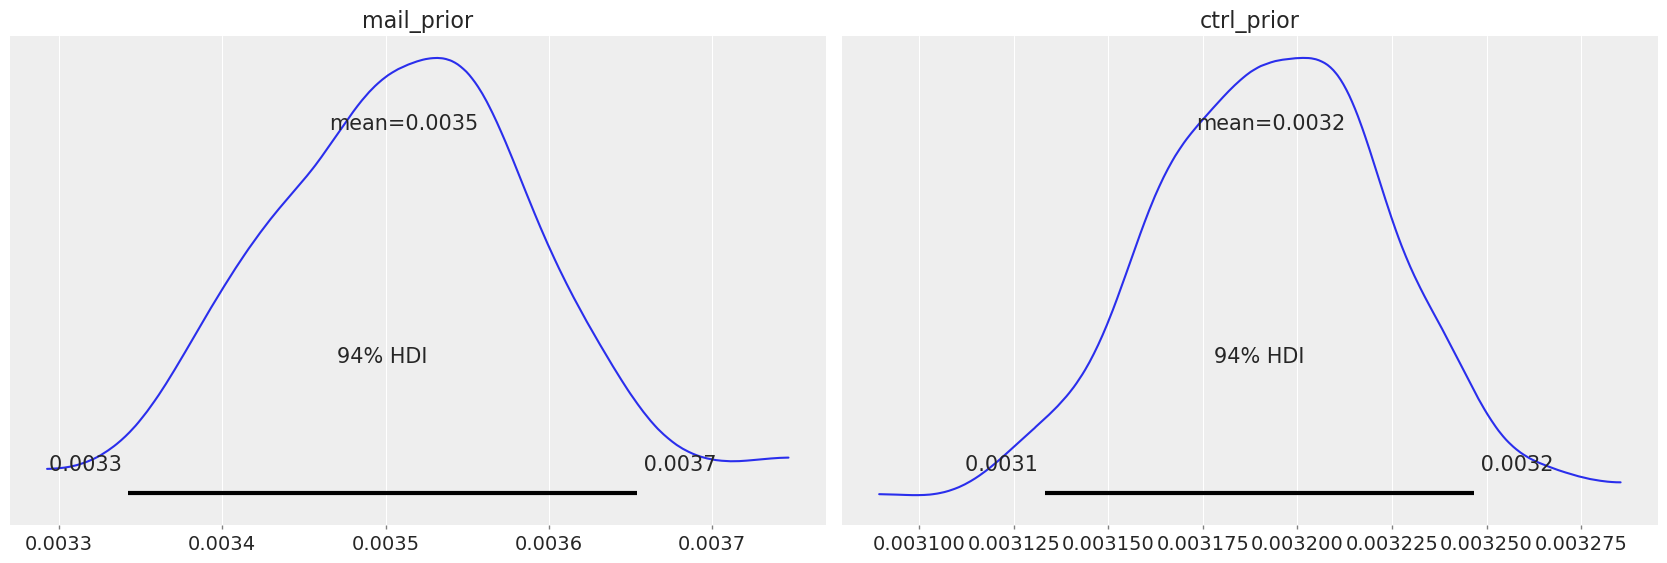

In [54]:
### Plot Posterior - priors 2
az.plot_posterior(trace_abtest)

- 94% probability that the mail rate was between 0.33% & 0.36% w/a MLE of 0.35%
- 94% probability that the mail rate was between 0.31% & 0.32% w/a MLE of 0.32%

In [61]:
### Sampling from posterior - priors 1
mail_sample = trace_abtest.posterior['mail_prior'].values
control_sample = trace_abtest.posterior['ctrl_prior'].values
print(f'Probability that mailed outperformed control is: {(mail_sample > control_sample).mean():.1%}.')

Probability that mailed outperformed control is: 100.0%.


In [56]:
### Sampling from posterior - priors 2
mail_sample = trace_abtest.posterior['mail_prior'].values
control_sample = trace_abtest.posterior['ctrl_prior'].values
print(f'Probability that mailed outperformed control is: {(mail_sample > control_sample).mean():.1%}.')

Probability that mailed outperformed control is: 100.0%.
